In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import inv

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Getting the data
customer_data_df = pd.read_csv("../Data/pre_processed_data_1.csv", sep = "\t")
customer_data_df.head()

,Income,Response,Kids,Expenses,TotalAcceptedCmp,NumTotalPurchases,Age,Days_Customer,Related,Single,Unrelated,Post-Graduate,Under-Graduate
0,58138.0,1,0,1617,1,25,65,3668,0.0,1.0,0.0,1.0,0.0
1,46344.0,0,2,27,0,6,68,2822,0.0,1.0,0.0,1.0,0.0
2,71613.0,0,0,776,0,21,57,3169,1.0,0.0,0.0,1.0,0.0
3,26646.0,0,1,53,0,8,38,2762,1.0,0.0,0.0,1.0,0.0
4,58293.0,0,1,422,0,19,41,3018,1.0,0.0,0.0,1.0,0.0


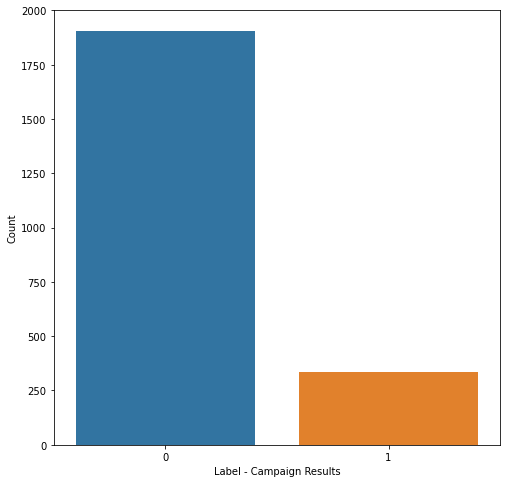

In [3]:
# Distribution of the labels in the dataset
plt.rcParams["figure.figsize"] = (8, 8)
sns.countplot(customer_data_df["Response"])
plt.grid(False)
plt.xlabel("Label - Campaign Results")
plt.ylabel("Count")
plt.show()

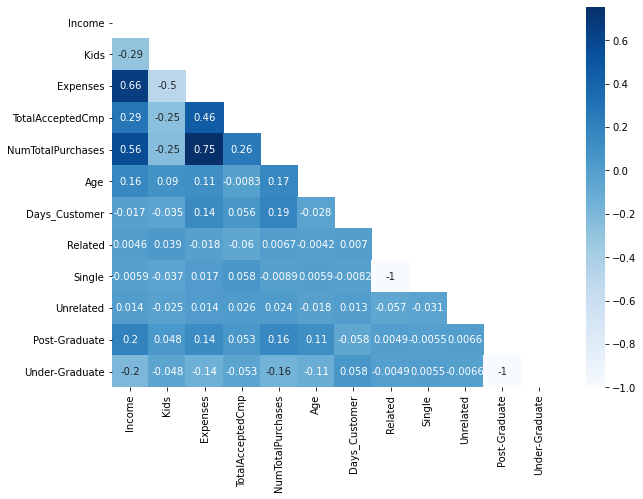

In [4]:
# plot correlation matrix
corr = customer_data_df.drop("Response", axis =1).corr()
corr = corr.mask(np.triu(np.ones(corr.shape)).astype(np.bool))
#corr.style.background_gradient(cmap='coolwarm')
plt.figure(figsize=(10,7))
sns.heatmap(corr,annot = True, cmap="Blues")
plt.show()

In [5]:
# Splitting the dataset
data_X = customer_data_df.drop(columns=['Response'])
data_y = customer_data_df['Response']
print(data_X.columns)

Index(['Income', 'Kids', 'Expenses', 'TotalAcceptedCmp', 'NumTotalPurchases',
       'Age', 'Days_Customer', 'Related', 'Single', 'Unrelated',
       'Post-Graduate', 'Under-Graduate'],
      dtype='object')


In [6]:
# Pre-Processing the data

# Note that our data is very imbalanced, so use stratified split
# Split the dataset into training (80%), and test (20%) sets
data_X_train, data_X_test, data_y_train, data_y_test = train_test_split(data_X, 
                                                                        data_y, 
                                                                        train_size = 0.8,
                                                                        stratify = data_y, 
                                                                        random_state = 42)

# Standardize the columns in the feature matrices
ss = StandardScaler()
data_X_train = ss.fit_transform(data_X_train)
data_X_test = ss.transform(data_X_test)

# Add a column of ones to the feature matrices of train, validation and test dataset
data_X_train = (np.column_stack((np.ones(len(data_X_train)),data_X_train)))
data_X_test = (np.column_stack((np.ones(len(data_X_test)),data_X_test)))

In [7]:
from sklearn.linear_model import LogisticRegression
logi = LogisticRegression()
logi.fit(data_X_train, data_y_train)

y_pred = logi.predict(data_X_test)

print(f"Accuracy Score for Dev Data: {logi.score(data_X_train, data_y_train) * 100}")
print(f"Accuracy Score for Testing Data: {logi.score(data_X_test, data_y_test) * 100}")
print(f"F-1 Score for Testing Data: {f1_score(data_y_test, y_pred)}")

Accuracy Score for Dev Data: 93.359375
Accuracy Score for Testing Data: 91.07142857142857
F-1 Score for Testing Data: 0.6721311475409837


In [8]:
param_grid = {
    'tol': [1e-5, 1e-4, 1e-3, 0.1],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty':  ['none', 'l1', 'l2', 'elasticnet'],
    'C': np.logspace(-3,3,7)
}

pipe = make_pipeline(GridSearchCV(LogisticRegression(),param_grid = param_grid, \
                                  cv = 5, \
                                  scoring = 'f1', \
                                  refit = 'f1',\
                                  return_train_score = True))

pipe.fit(data_X_train, data_y_train)

grid_search_results = pipe.named_steps["gridsearchcv"]
grid_search_result_tol = grid_search_results.best_params_['tol']
grid_search_result_penalty = grid_search_results.best_params_['penalty']
grid_search_result_solver = grid_search_results.best_params_['solver']
grid_search_result_C = grid_search_results.best_params_['C']

print(f"Best value of hyperparameter tol is: {grid_search_result_tol}")
print(f"Best penalty is: {grid_search_result_penalty}")
print(f"Best solver is: {grid_search_result_solver}")
print(f"Best value of hyperparameter C is: {grid_search_result_C}")
print(f"F-1 Score for Testing Data: {pipe.score(data_X_test, data_y_test)}")

Best value of hyperparameter tol is: 0.1
Best penalty is: l2
Best solver is: sag
Best value of hyperparameter C is: 1000.0
F-1 Score for Testing Data: 0.7086614173228347


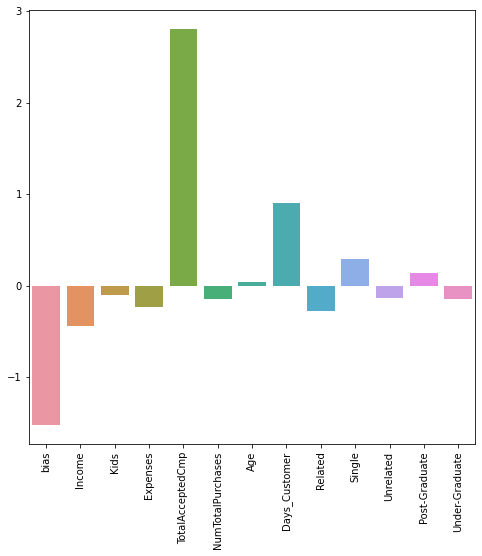

In [9]:
logi_best = LogisticRegression(C = grid_search_result_C, 
                               penalty = grid_search_result_penalty,
                               solver = grid_search_result_solver, 
                               tol = grid_search_result_tol)
logi_best.fit(data_X_train, data_y_train)
y_pred_best = logi_best.predict(data_X_test)

col_names = data_X.columns.tolist()
col_names.insert(0,'bias')
sns.barplot(col_names, logi_best.coef_[0])
plt.xticks(rotation=90)
plt.show()

In [10]:
print(f"Accuracy Score for Dev Data: {logi_best.score(data_X_train, data_y_train) * 100}")
print(f"Accuracy Score for Testing Data: {logi_best.score(data_X_test, data_y_test) * 100}")
print(f"F-1 Score for Testing Data: {f1_score(data_y_test, y_pred_best)}")

Accuracy Score for Dev Data: 93.47098214285714
Accuracy Score for Testing Data: 91.29464285714286
F-1 Score for Testing Data: 0.688


In [11]:
model_name_saved = "../SavedModels/LogisticClfWoSmote.pkl"
with open(model_name_saved, 'wb') as file:
    pickle.dump(logi_best, file)

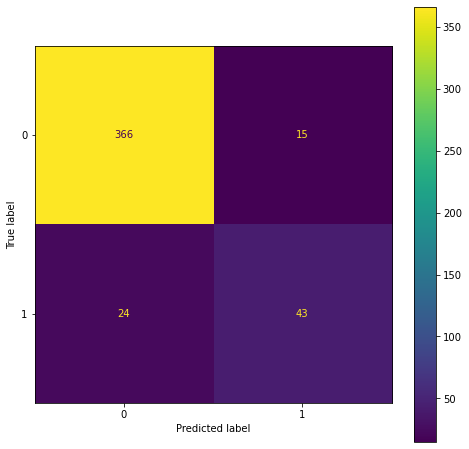

In [12]:
plot_confusion_matrix(logi_best, data_X_test, data_y_test)
plt.show()

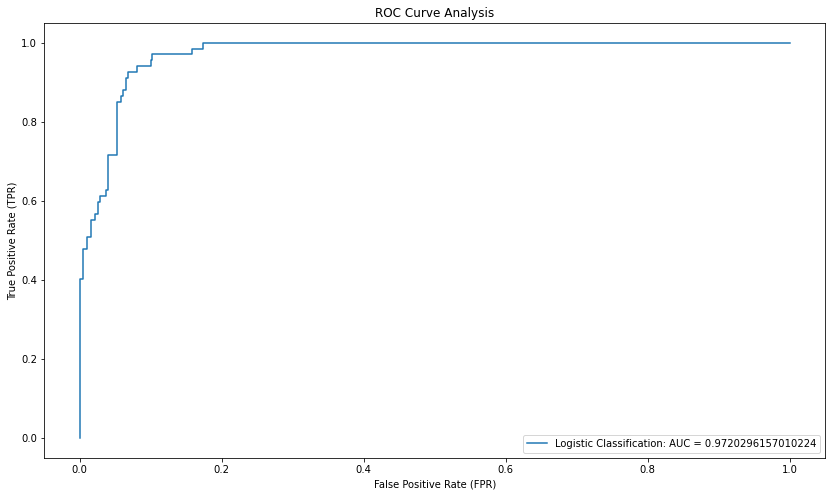

In [13]:
# Making predictions and plotting the ROC
fig = plt.figure(figsize = (14, 8))

y_pred_proba = logi_best.predict_proba(data_X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(data_y_test, y_pred_proba, pos_label = 1)
auc_score = roc_auc_score(data_y_test, y_pred_proba)
plt.plot(fpr, tpr, label = f"Logistic Classification: AUC = {auc_score}")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve Analysis")
plt.legend(loc = "lower right")
plt.show()

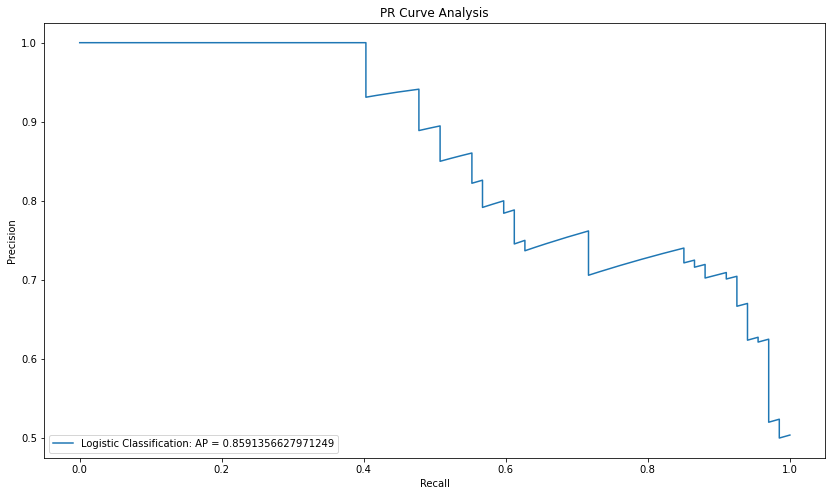

In [14]:
fig = plt.figure(figsize = (14, 8))

y_pred_proba = logi_best.predict_proba(data_X_test)[:, 1]
ap = average_precision_score(data_y_test, y_pred_proba)
precision, recall, thresholds = precision_recall_curve(data_y_test, y_pred_proba, pos_label = 1)

plt.plot(recall, precision, label = f"Logistic Classification: AP = {ap}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve Analysis")
plt.legend(loc = "lower left")
plt.show()

In [15]:
# try SMOTE to balance data
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 42)
X_dev_smote, y_dev_smote = smote.fit_resample(data_X_train, data_y_train)
print("Shape of SMOTE development feature:", X_dev_smote.shape)
y_dev_smote.value_counts()

Shape of SMOTE development feature: (3050, 13)


0    1525
1    1525
Name: Response, dtype: int64

In [16]:
param_grid = {
    'tol': [1e-5, 1e-4, 1e-3, 0.1],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty':  ['none', 'l1', 'l2', 'elasticnet'],
    'C': np.logspace(-3,3,7)
}

pipe_smote = make_pipeline(GridSearchCV(LogisticRegression(),param_grid = param_grid, \
                                  cv = 5, \
                                  scoring = 'f1', \
                                  refit = 'f1',\
                                  return_train_score = True))

pipe_smote.fit(X_dev_smote, y_dev_smote)

grid_search_results_smote = pipe_smote.named_steps["gridsearchcv"]
grid_search_result_tol_smote = grid_search_results_smote.best_params_['tol']
grid_search_result_penalty_smote = grid_search_results_smote.best_params_['penalty']
grid_search_result_solver_smote = grid_search_results_smote.best_params_['solver']
grid_search_result_C_smote = grid_search_results_smote.best_params_['C']

print(f"Best value of hyperparameter tol is: {grid_search_result_tol_smote}")
print(f"Best penalty is: {grid_search_result_penalty_smote}")
print(f"Best solver is: {grid_search_result_solver_smote}")
print(f"Best value of hyperparameter C is: {grid_search_result_C_smote}")
print(f"F-1 Score for Testing Data: {pipe_smote.score(data_X_test, data_y_test)}")

Best value of hyperparameter tol is: 0.1
Best penalty is: l1
Best solver is: liblinear
Best value of hyperparameter C is: 10.0
F-1 Score for Testing Data: 0.7974683544303798


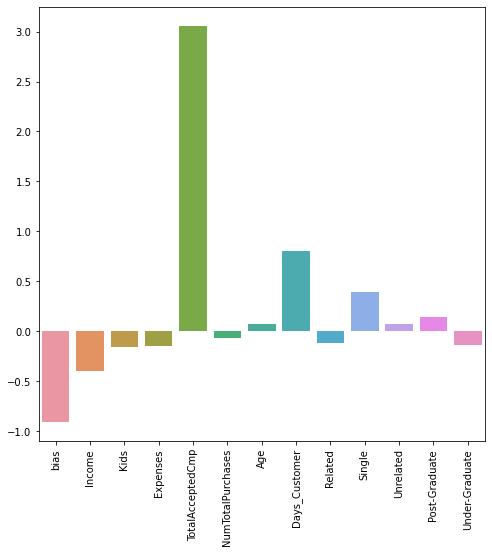

In [17]:
logi_smote_best = LogisticRegression(C = grid_search_result_C_smote, 
                               penalty = grid_search_result_penalty_smote,
                               solver = grid_search_result_solver_smote, 
                               tol = grid_search_result_tol_smote)
logi_smote_best.fit(X_dev_smote, y_dev_smote)
y_pred_smote_best = logi_smote_best.predict(data_X_test)

col_names = data_X.columns.tolist()
col_names.insert(0,'bias')
sns.barplot(col_names, logi_smote_best.coef_[0])
plt.xticks(rotation=90)
plt.show()

In [18]:
print(f"Accuracy Score for Dev Data: {logi_smote_best.score(X_dev_smote, y_dev_smote) * 100}")
print(f"Accuracy Score for Testing Data: {logi_smote_best.score(data_X_test, data_y_test) * 100}")
print(f"F-1 Score for Testing Data: {f1_score(data_y_test, y_pred_smote_best)}")

Accuracy Score for Dev Data: 94.1967213114754
Accuracy Score for Testing Data: 92.1875
F-1 Score for Testing Data: 0.782608695652174


In [19]:
model_name_saved = "../SavedModels/LogisticClfWithSmote.pkl"
with open(model_name_saved, 'wb') as file:
    pickle.dump(logi_smote_best, file)

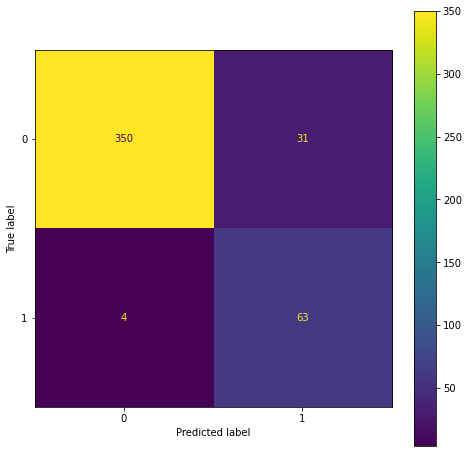

In [20]:
plot_confusion_matrix(logi_smote_best, data_X_test, data_y_test)
plt.show()

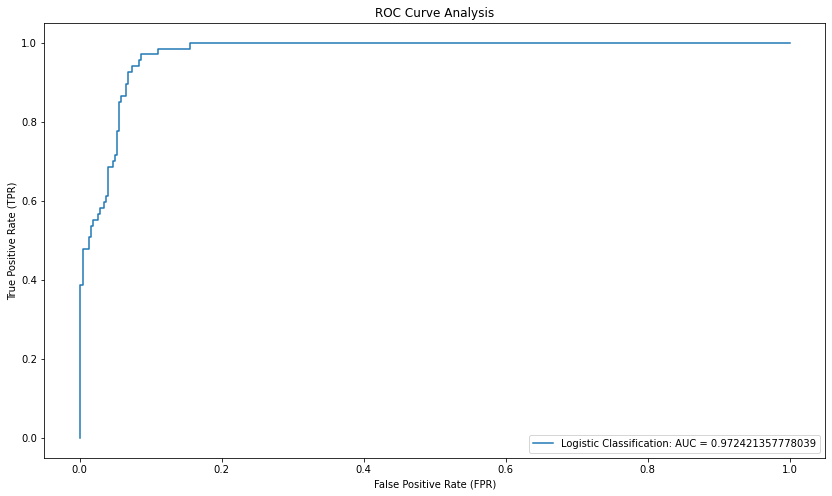

In [21]:
# Making predictions and plotting the ROC
fig = plt.figure(figsize = (14, 8))

y_pred_proba = logi_smote_best.predict_proba(data_X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(data_y_test, y_pred_proba, pos_label = 1)
auc_score = roc_auc_score(data_y_test, y_pred_proba)
plt.plot(fpr, tpr, label = f"Logistic Classification: AUC = {auc_score}")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve Analysis")
plt.legend(loc = "lower right")
plt.show()

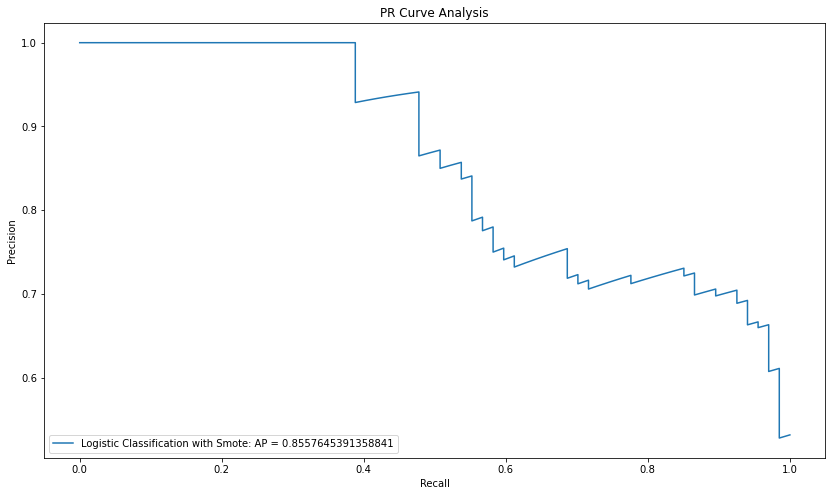

In [22]:
fig = plt.figure(figsize = (14, 8))

y_pred_proba = logi_smote_best.predict_proba(data_X_test)[:, 1]
ap = average_precision_score(data_y_test, y_pred_proba)
precision, recall, thresholds = precision_recall_curve(data_y_test, y_pred_proba, pos_label = 1)

plt.plot(recall, precision, label = f"Logistic Classification with Smote: AP = {ap}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve Analysis")
plt.legend(loc = "lower left")
plt.show()